# Deep denoising auto-encoder and MLP based multi-output regression on TCGA multi-omics data
## DNA Methylation and CNA to RNA-Seq

# Setting environment

Seeding the random number generators

In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            # have reproducible behavior for certain hash-based operations.
import os
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
import numpy as np
np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
import random as rn
rn.seed(12345)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
import tensorflow as tf
tf.random.set_seed(1234)

# Force TensorFlow to use single thread.
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
#from keras import backend as K
from tensorflow.python.keras import backend as K

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)


Importing libraries

In [ ]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

In [ ]:
def rSquared(true,predicted):
    cols = predicted.shape[1]
    rsq = np.zeros(shape=(cols), dtype = np.float32)
    for j in range(cols):
        rsq[j] = r2_score(true[:,j], predicted[:,j])
    return rsq

# Loading data

Importing data from pre-processed csv files (Change paths accordingly)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls "/content/drive/My Drive/CS309_group_project/Preprocessed_Data"

LIHC_labels.csv                LIHC_preprocessed_RNASeq.csv  OV_preprocessed_RNASeq.csv
LIHC_preprocessed_CNA.csv      OV_preprocessed_CNA.csv
LIHC_preprocessed_DNAMeth.csv  OV_preprocessed_DNAMeth.csv


In [ ]:
preprocessed_DNAMeth = pd.read_csv('/content/drive/My Drive/CS309_group_project/Preprocessed_Data/LIHC_preprocessed_DNAMeth.csv')
preprocessed_RNASeq = pd.read_csv('/content/drive/My Drive/CS309_group_project/Preprocessed_Data/LIHC_preprocessed_RNASeq.csv')
preprocessed_CNA = pd.read_csv('/content/drive/My Drive/CS309_group_project/Preprocessed_Data/LIHC_preprocessed_CNA.csv')
labels = pd.read_csv('/content/drive/My Drive/CS309_group_project/Preprocessed_Data/LIHC_labels.csv')

In [ ]:
preprocessed_DNAMeth = pd.read_csv('/content/drive/My Drive/CS309_group_project/Preprocessed_Data/OV_preprocessed_DNAMeth.csv')
preprocessed_RNASeq = pd.read_csv('/content/drive/My Drive/CS309_group_project/Preprocessed_Data/OV_preprocessed_RNASeq.csv')
preprocessed_CNA = pd.read_csv('/content/drive/My Drive/CS309_group_project/Preprocessed_Data/OV_preprocessed_CNA.csv')
#labels = pd.read_csv('/content/drive/My Drive/CS309_group_project/Preprocessed_Data/LIHC_labels.csv')

In [ ]:
x1 = preprocessed_DNAMeth
x2 = preprocessed_CNA
y = preprocessed_RNASeq

Concatenating Methylation and CNV features

In [ ]:
x1 = pd.DataFrame(x1)
x2 = pd.DataFrame(x2)
df = [x1, x2]
z = pd.concat(df,axis=1)

Splitting the data into training and testing datasets

In [ ]:

# Example data: X as features and y as target variable
# Replace these with your actual data

# List to store train-test splits
splits = []

# Perform train_test_split 5 times
for i in range(5):
    x_train, x_test, y_train, y_test, labels_train, labels_test = train_test_split(z, y, labels, test_size=0.2, random_state=i)
    splits.append((x_train, x_test, y_train, y_test,labels_train, labels_test))

In [ ]:
import numpy as np

# Number of splits
num_splits = 5

# Calculate number of rows
nrows = z.shape[0]

# Calculate number of rows per split
rows_per_split = nrows // num_splits

# List to store train-test splits
splits = []

# Perform split
for i in range(num_splits):
    start_index = i * rows_per_split
    end_index = (i + 1) * rows_per_split if i < num_splits - 1 else nrows

    test_indices = np.arange(start_index, end_index)
    train_indices = np.delete(np.arange(nrows), test_indices)

    x_train, x_test = z.iloc[train_indices,], z.iloc[test_indices,]
    y_train, y_test = y.iloc[train_indices,], y.iloc[test_indices,]
    labels_train, labels_test = labels.iloc[train_indices], labels.iloc[test_indices]

    splits.append((x_train, x_test, y_train, y_test, labels_train, labels_test))


In [ ]:
x_train, x_test, y_train, y_test, labels_train, labels_test = train_test_split(z, y, labels, test_size=0.2)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(z, y, test_size=0.2)

Scaling the data within [0-1] range

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'splits' is a list containing the train-test split pairs
# Format of splits: [(X_train1, X_test1, y_train1, y_test1), ..., (X_train5, X_test5, y_train5, y_test5)]

# List to store the scaled data
scaled_splits = []

# Setup MinMaxScaler
scaler = MinMaxScaler()

# Loop through each split and scale the data
for X_train, X_test, y_train, y_test,labels_train, labels_test in splits:
    # Fit the scaler on the training data and transform it
    X_train_scaled = scaler.fit_transform(X_train)
    # Transform the test data
    X_test_scaled = scaler.transform(X_test)

    # Store the scaled splits
    scaled_splits.append((X_train_scaled, X_test_scaled, y_train, y_test,labels_train, labels_test))


In [ ]:
scalar = MinMaxScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)

Adding gaussian noise

In [ ]:
import numpy as np

# Assuming x_train_list and x_test_list are lists containing multiple arrays of training and testing data
# e.g., x_train_list = [x_train1, x_train2, ..., x_trainN]
#       x_test_list = [x_test1, x_test2, ..., x_testN]

# Initialize noise factor
noise_factor = 0.5

# Lists to store noisy data
x_train_noisy_list = []
x_test_noisy_list = []

# Loop through each pair of train and test data
for X_train, X_test, y_train, y_test,a,b in scaled_splits:
    # Add noise to the original data
    x_train_noisy = x_train + noise_factor * np.random.normal(0.0, 1.0, x_train.shape)
    x_test_noisy = x_test + noise_factor * np.random.normal(0.0, 1.0, x_test.shape)

    # Clip the noisy data to be within the range [0, 1]
    x_train_noisy_clipped = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy_clipped = np.clip(x_test_noisy, 0., 1.)

    # Store the noisy and clipped data
    x_train_noisy_list.append(x_train_noisy_clipped)
    x_test_noisy_list.append(x_test_noisy_clipped)

# At this point, you have noisy and clipped versions of your multiple train and test sets.
# Each pair corresponds to the entries in x_train_noisy_list and x_test_noisy_list.


In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(0.0, 1.0, x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(0.0, 1.0, x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Dimension Reduction/Feature Extraction using DDAE

Setting the no. of input and output neurons

In [ ]:
num_in_neurons = z.shape[1]
num_out_neurons = y.shape[1]

In [ ]:
'''
# Auto-encoder to extract features from DNA Methylation and CNV data
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with tf.device('/gpu:0'):
    # this is the size of our encoded representations
    encoding_dim1 = 500
    encoding_dim2 = 200

    lambda_act = 0.0001
    lambda_weight = 0.001
    # this is our input placeholder
    input_data = Input(shape=(num_in_neurons,))
    # first encoded representation of the input
    encoded = Dense(encoding_dim1, activation='relu', activity_regularizer=regularizers.l1(lambda_act), kernel_regularizer=regularizers.l2(lambda_weight), name='encoder1')(input_data)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.5)(encoded)

    # second encoded representation of the input

    encoded = Dense(encoding_dim2, activation='relu', activity_regularizer=regularizers.l1(lambda_act), kernel_regularizer=regularizers.l2(lambda_weight), name='encoder2')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.5)(encoded)

    # first lossy reconstruction of the input

    decoded = Dense(encoding_dim1, activation='relu', name='decoder1')(encoded)
    decoded = BatchNormalization()(decoded)

    # the final lossy reconstruction of the input
    decoded = Dense(num_in_neurons, activation='sigmoid', name='decoder2')(decoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_data, outputs=decoded)

    myencoder = Model(inputs=input_data, outputs=encoded)
    autoencoder.compile(optimizer=Adam(), loss='mse')
      # setup callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]
    # training
    print('training the autoencoder')
    autoencoder.fit(x_train_noisy, x_train,
                    epochs=25,
                    batch_size=8,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test),
                    callbacks=callbacks)
    autoencoder.trainable = False   #freeze autoencoder weights
'''

"\n# Auto-encoder to extract features from DNA Methylation and CNV data\nimport tensorflow as tf\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization\nfrom tensorflow.keras import regularizers\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint\n\nwith tf.device('/gpu:0'):\n    # this is the size of our encoded representations\n    encoding_dim1 = 500\n    encoding_dim2 = 200\n\n    lambda_act = 0.0001\n    lambda_weight = 0.001\n    # this is our input placeholder\n    input_data = Input(shape=(num_in_neurons,))\n    # first encoded representation of the input\n    encoded = Dense(encoding_dim1, activation='relu', activity_regularizer=regularizers.l1(lambda_act), kernel_regularizer=regularizers.l2(lambda_weight), name='encoder1')(input_data)\n    encoded = BatchNormalization()(encoded)\n    encoded = Dropout(0.5)(encoded)\n\n    # second encoded represe

Our optimized DDAE

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Auto-encoder to extract features from DNA Methylation and CNV data
import time
# Record the start time
start_time = time.time()
with tf.device('/gpu:0'):
    # this is the size of our encoded representations
    encoding_dim1 = 500
    encoding_dim2 = 200

    lambda_act = 0.0001
    lambda_weight = 0.001

    # this is our input placeholder
    input_data = Input(shape=(num_in_neurons,))

    # first encoded representation of the input
    encoded = Dense(encoding_dim1, activation='relu', activity_regularizer=regularizers.l1(lambda_act), kernel_regularizer=regularizers.l2(lambda_weight), name='encoder1')(input_data)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.5)(encoded)

    # second encoded representation of the input

    encoded = Dense(encoding_dim2, activation='relu', activity_regularizer=regularizers.l1(lambda_act), kernel_regularizer=regularizers.l2(lambda_weight), name='encoder2')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.5)(encoded)

    # first lossy reconstruction of the input

    decoded = Dense(encoding_dim1, activation='relu', name='decoder1')(encoded)
    decoded = BatchNormalization()(decoded)

    # the final lossy reconstruction of the input
    decoded = Dense(num_in_neurons, activation='sigmoid', name='decoder2')(decoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_data, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mse')

    # setup callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]

    # training
    print('Training the autoencoder')
    autoencoder.fit(x_train_noisy, x_train,
                    epochs=50,
                    batch_size=8,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test),
                    callbacks=callbacks)

    # Load best model
    autoencoder.load_weights('best_model.h5')

    # Freeze the weights
    autoencoder.trainable = False
# Record the end time
end_time = time.time()
# Calculate the running time
running_time = end_time - start_time
print ('running time for autodecoder is ',running_time,'s')


Training the autoencoder
Epoch 1/50
55/56 [============================>.] - ETA: 0s - loss: 0.4197
Epoch 1: val_loss improved from inf to 0.24458, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 8s 90ms/step - loss: 0.4181 - val_loss: 0.2446
Epoch 2/50
54/56 [===========================>..] - ETA: 0s - loss: 0.3672
Epoch 2: val_loss did not improve from 0.24458
56/56 [==============================] - 1s 19ms/step - loss: 0.3721 - val_loss: 0.5693
Epoch 3/50
54/56 [===========================>..] - ETA: 0s - loss: 0.5431
Epoch 3: val_loss did not improve from 0.24458
56/56 [==============================] - 1s 18ms/step - loss: 0.5413 - val_loss: 0.5058
Epoch 4/50
53/56 [===========================>..] - ETA: 0s - loss: 0.3629
Epoch 4: val_loss did not improve from 0.24458
56/56 [==============================] - 1s 18ms/step - loss: 0.3600 - val_loss: 0.3129
Epoch 5/50
55/56 [============================>.] - ETA: 0s - loss: 0.2701
Epoch 5: val_loss did not improve from 0.24458
56/56 [==============================] - 1s 18ms/step - loss: 0.2699 - val_loss: 0.3048
Epoch 6/50
56/56 [==============================] - ETA: 0s - loss: 0.24

Running our DDAE model via K-fold

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

# List of datasets for model training
# Each element in this list is a tuple of (x_train, x_test)


# Make sure to define 'num_in_neurons' beforehand

running_times = []
autoencoders = []


for i, (X_train, X_test, y_train, y_test,a,b) in enumerate(scaled_splits, 1):
    x_train_noisy = x_train_noisy_list[i-1]
    start_time = time.time()  # Record the start time for the current model training
    with tf.device('/gpu:0'):
    # this is the size of our encoded representations
      encoding_dim1 = 500
      encoding_dim2 = 200

      lambda_act = 0.0001
      lambda_weight = 0.001

    # this is our input placeholder
      input_data = Input(shape=(num_in_neurons,))

    # first encoded representation of the input
      encoded = Dense(encoding_dim1, activation='relu', activity_regularizer=regularizers.l1(lambda_act), kernel_regularizer=regularizers.l2(lambda_weight), name='encoder1')(input_data)
      encoded = BatchNormalization()(encoded)
      encoded = Dropout(0.5)(encoded)

    # second encoded representation of the input

      encoded = Dense(encoding_dim2, activation='relu', activity_regularizer=regularizers.l1(lambda_act), kernel_regularizer=regularizers.l2(lambda_weight), name='encoder2')(encoded)
      encoded = BatchNormalization()(encoded)
      encoded = Dropout(0.5)(encoded)

    # first lossy reconstruction of the input

      decoded = Dense(encoding_dim1, activation='relu', name='decoder1')(encoded)
      decoded = BatchNormalization()(decoded)

    # the final lossy reconstruction of the input
      decoded = Dense(num_in_neurons, activation='sigmoid', name='decoder2')(decoded)

    # this model maps an input to its reconstruction
      autoencoder = Model(inputs=input_data, outputs=decoded)
      autoencoder.compile(optimizer=Adam(), loss='mse')

    # setup callbacks
      callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
      ]

      print(f'Training the autoencoder on dataset {i}')
      autoencoder.fit(x_train_noisy, x_train,
                        epochs=50,
                        batch_size=8,
                        shuffle=True,
                        validation_data=(x_test_noisy, x_test),
                        callbacks=callbacks)

        # Load best model
      autoencoder.load_weights('best_model.h5')

        # Freeze the weights
      autoencoder.trainable = False
      autoencoders.append(autoencoder)
    # Record the end time, calculate the running time, and store running times for each model
      end_time = time.time()
      running_time = end_time - start_time
      running_times.append(running_time)
      print(f'Running time for autoencoder {i} is {running_time}s')

# Now 'running_times' list has the running times for training each of the five autoencoders.


Training the autoencoder on dataset 1
Epoch 1/50
40/41 [============================>.] - ETA: 0s - loss: 0.4740
Epoch 1: val_loss improved from inf to 0.34758, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 10s 186ms/step - loss: 0.4727 - val_loss: 0.3476
Epoch 2/50
40/41 [============================>.] - ETA: 0s - loss: 0.2885
Epoch 2: val_loss improved from 0.34758 to 0.34549, saving model to best_model.h5
41/41 [==============================] - 3s 84ms/step - loss: 0.2887 - val_loss: 0.3455
Epoch 3/50
40/41 [============================>.] - ETA: 0s - loss: 0.3681
Epoch 3: val_loss did not improve from 0.34549
41/41 [==============================] - 1s 21ms/step - loss: 0.3686 - val_loss: 0.4637
Epoch 4/50
40/41 [============================>.] - ETA: 0s - loss: 0.3887
Epoch 4: val_loss did not improve from 0.34549
41/41 [==============================] - 1s 21ms/step - loss: 0.3882 - val_loss: 0.3603
Epoch 5/50
40/41 [============================>.] - ETA: 0s - loss: 0.3289
Epoch 5: val_loss improved from 0.34549 to 0.34060, saving model to best_model.h5
41/41 [==============================] - 5s 124ms/step - loss: 0.3287 - val_loss: 0.3406

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 9s 150ms/step - loss: 0.4750 - val_loss: 0.3480
Epoch 2/50
40/41 [============================>.] - ETA: 0s - loss: 0.2742
Epoch 2: val_loss did not improve from 0.34804
41/41 [==============================] - 1s 20ms/step - loss: 0.2747 - val_loss: 0.3564
Epoch 3/50
40/41 [============================>.] - ETA: 0s - loss: 0.3463
Epoch 3: val_loss did not improve from 0.34804
41/41 [==============================] - 1s 21ms/step - loss: 0.3466 - val_loss: 0.4214
Epoch 4/50
40/41 [============================>.] - ETA: 0s - loss: 0.4203
Epoch 4: val_loss did not improve from 0.34804
41/41 [==============================] - 1s 21ms/step - loss: 0.4199 - val_loss: 0.4122
Epoch 5/50
40/41 [============================>.] - ETA: 0s - loss: 0.3190
Epoch 5: val_loss improved from 0.34804 to 0.32134, saving model to best_model.h5
41/41 [==============================] - 11s 278ms/step - loss: 0.3187 - val_loss: 0.3213
Epoch 6/50
40/41 [================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 11s 190ms/step - loss: 0.4785 - val_loss: 0.3512
Epoch 2/50
40/41 [============================>.] - ETA: 0s - loss: 0.2732
Epoch 2: val_loss improved from 0.35118 to 0.28812, saving model to best_model.h5
41/41 [==============================] - 5s 134ms/step - loss: 0.2731 - val_loss: 0.2881
Epoch 3/50
40/41 [============================>.] - ETA: 0s - loss: 0.3357
Epoch 3: val_loss did not improve from 0.28812
41/41 [==============================] - 1s 21ms/step - loss: 0.3364 - val_loss: 0.4548
Epoch 4/50
40/41 [============================>.] - ETA: 0s - loss: 0.3819
Epoch 4: val_loss did not improve from 0.28812
41/41 [==============================] - 1s 21ms/step - loss: 0.3816 - val_loss: 0.4038
Epoch 5/50
40/41 [============================>.] - ETA: 0s - loss: 0.3310
Epoch 5: val_loss did not improve from 0.28812
41/41 [==============================] - 1s 21ms/step - loss: 0.3309 - val_loss: 0.4668
Epoch 6/50
40/41 [================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 10s 184ms/step - loss: 0.4807 - val_loss: 0.3462
Epoch 2/50
40/41 [============================>.] - ETA: 0s - loss: 0.2719
Epoch 2: val_loss improved from 0.34625 to 0.30303, saving model to best_model.h5
41/41 [==============================] - 11s 269ms/step - loss: 0.2719 - val_loss: 0.3030
Epoch 3/50
40/41 [============================>.] - ETA: 0s - loss: 0.4129
Epoch 3: val_loss did not improve from 0.30303
41/41 [==============================] - 1s 21ms/step - loss: 0.4135 - val_loss: 0.5373
Epoch 4/50
40/41 [============================>.] - ETA: 0s - loss: 0.3878
Epoch 4: val_loss did not improve from 0.30303
41/41 [==============================] - 1s 21ms/step - loss: 0.3870 - val_loss: 0.3339
Epoch 5/50
40/41 [============================>.] - ETA: 0s - loss: 0.2754
Epoch 5: val_loss improved from 0.30303 to 0.28658, saving model to best_model.h5
41/41 [==============================] - 8s 190ms/step - loss: 0.2753 - val_loss: 0.28

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 14s 298ms/step - loss: 0.4706 - val_loss: 0.3446
Epoch 2/50
40/41 [============================>.] - ETA: 0s - loss: 0.2615
Epoch 2: val_loss improved from 0.34459 to 0.27683, saving model to best_model.h5
41/41 [==============================] - 10s 256ms/step - loss: 0.2615 - val_loss: 0.2768
Epoch 3/50
40/41 [============================>.] - ETA: 0s - loss: 0.3532
Epoch 3: val_loss did not improve from 0.27683
41/41 [==============================] - 1s 21ms/step - loss: 0.3536 - val_loss: 0.4148
Epoch 4/50
40/41 [============================>.] - ETA: 0s - loss: 0.4182
Epoch 4: val_loss did not improve from 0.27683
41/41 [==============================] - 1s 21ms/step - loss: 0.4182 - val_loss: 0.4806
Epoch 5/50
40/41 [============================>.] - ETA: 0s - loss: 0.3557
Epoch 5: val_loss did not improve from 0.27683
41/41 [==============================] - 1s 20ms/step - loss: 0.3552 - val_loss: 0.3708
Epoch 6/50
40/41 [===============

Author's original MLP model

In [ ]:
num_hidden = encoding_dim2
with tf.device('/gpu:0'):
    x = autoencoder.get_layer('encoder2').output
    x = Dropout(0.2)(x)             # adding 20% dropout
    h = Dense(int(num_hidden * 3), activation='relu', name='hidden1')(x)
    h = Dropout(0.5)(h)             # adding 50% dropout
    h = Dense(int(num_hidden * 5), activation='relu', name='hidden2')(h)
    h = Dropout(0.5)(h)             # adding 50% dropout
    y = Dense(num_out_neurons, activation='linear', name='prediction')(h)
    mlpRegressor = Model(inputs=autoencoder.inputs, outputs=y)

    # Compile model
    mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])    # or loss='mae'

    # Fit the model
    print('training the MLP multi-output regressor')
    mlpRegressor.fit(x_train, y_train, epochs=50, batch_size=8)

    y_pred = mlpRegressor.predict(x_test)

    actual_mean = pd.DataFrame(y_test.mean(axis=0))
    pred_mean = pd.DataFrame(y_pred.mean(axis=0))
# Record the end time
end_time = time.time()
# Calculate the running time
running_time = end_time - start_time

print("The code took {:.2f} seconds to run.".format(running_time))
print('MSE: (Actual Vs. Predicted)', mean_squared_error(y_test, y_pred))
print('r^2 value: (Mean of actual Vs. Mean of Predicted)', r2_score(actual_mean, pred_mean))
#print(actual_mean)
#print(pred_mean)

training the MLP multi-output regressor
Epoch 1/50
41/41 [==============================] - 3s 21ms/step - loss: 0.2861 - accuracy: 0.0000e+00
Epoch 2/50
41/41 [==============================] - 1s 19ms/step - loss: 0.2765 - accuracy: 0.0000e+00
Epoch 3/50
41/41 [==============================] - 1s 20ms/step - loss: 0.2760 - accuracy: 0.0000e+00
Epoch 4/50
41/41 [==============================] - 1s 19ms/step - loss: 0.2757 - accuracy: 0.0000e+00
Epoch 5/50
41/41 [==============================] - 1s 28ms/step - loss: 0.2755 - accuracy: 0.0000e+00
Epoch 6/50
41/41 [==============================] - 1s 19ms/step - loss: 0.2752 - accuracy: 0.0000e+00
Epoch 7/50
41/41 [==============================] - 1s 17ms/step - loss: 0.2750 - accuracy: 0.0000e+00
Epoch 8/50
41/41 [==============================] - 1s 16ms/step - loss: 0.2750 - accuracy: 0.0000e+00
Epoch 9/50
41/41 [==============================] - 1s 17ms/step - loss: 0.2748 - accuracy: 0.0000e+00
Epoch 10/50
41/41 [==============

Testing adding the prefered neuron number at the third layer

In [ ]:
num_hidden = encoding_dim2
with tf.device('/gpu:0'):
    x = autoencoder.get_layer('encoder2').output
    x = Dropout(0.2)(x)             # adding 20% dropout
    h = Dense(int(num_hidden * 3), activation='relu', name='hidden1')(x)
    h = Dropout(0.5)(h)             # adding 50% dropout
    h = Dense(int(num_hidden * 5), activation='relu', name='hidden2')(h)
    h = Dropout(0.5)(h)             # adding 50% dropout
    h = Dense(int(num_hidden * 2), activation='relu', name='hidden3')(h)
    h = Dropout(0.5)(h)             # adding 50% dropout
    y = Dense(num_out_neurons, activation='linear', name='prediction')(h)
    mlpRegressor = Model(inputs=autoencoder.inputs, outputs=y)

    # Compile model
    mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])    # or loss='mae'

    # Fit the model
    print('training the MLP multi-output regressor')
    start_time = time.time()  # Record the start time for the current model training
    mlpRegressor.fit(x_train, y_train, epochs=50, batch_size=12)

    y_pred = mlpRegressor.predict(x_test)

    actual_mean = pd.DataFrame(y_test.mean(axis=0))
    pred_mean = pd.DataFrame(y_pred.mean(axis=0))
# Record the end time
end_time = time.time()
# Calculate the running time
running_time = end_time - start_time

print("The code took {:.2f} seconds to run.".format(running_time))
print('MSE: (Actual Vs. Predicted)', mean_squared_error(y_test, y_pred))
print('r^2 value: (Mean of actual Vs. Mean of Predicted)', r2_score(actual_mean, pred_mean))
#print(actual_mean)
#print(pred_mean)

training the MLP multi-output regressor
Epoch 1/50
37/37 [==============================] - 4s 14ms/step - loss: 0.2334 - accuracy: 0.0000e+00
Epoch 2/50
37/37 [==============================] - 0s 10ms/step - loss: 0.2048 - accuracy: 0.0000e+00
Epoch 3/50
37/37 [==============================] - 0s 9ms/step - loss: 0.2010 - accuracy: 0.0000e+00
Epoch 4/50
37/37 [==============================] - 0s 9ms/step - loss: 0.1984 - accuracy: 0.0000e+00
Epoch 5/50
37/37 [==============================] - 0s 10ms/step - loss: 0.1968 - accuracy: 0.0000e+00
Epoch 6/50
37/37 [==============================] - 0s 9ms/step - loss: 0.1965 - accuracy: 0.0000e+00
Epoch 7/50
37/37 [==============================] - 0s 9ms/step - loss: 0.1948 - accuracy: 0.0000e+00
Epoch 8/50
37/37 [==============================] - 0s 10ms/step - loss: 0.1954 - accuracy: 0.0000e+00
Epoch 9/50
37/37 [==============================] - 0s 9ms/step - loss: 0.1931 - accuracy: 0.0000e+00
Epoch 10/50
37/37 [===================

trying Leaky Relu

In [ ]:
num_hidden = encoding_dim2
from keras.layers import LeakyReLU, Dense, Dropout

with tf.device('/gpu:0'):
    x = autoencoder.get_layer('encoder2').output
    x = Dropout(0.2)(x)  # adding 20% dropout
    h = Dense(int(num_hidden * 3), name='hidden1')(x)
    h = LeakyReLU(alpha=0.01)(h)  # applying LeakyReLU
    h = Dropout(0.5)(h)  # adding 50% dropout
    h = Dense(int(num_hidden * 5), name='hidden2')(h)
    h = LeakyReLU(alpha=0.01)(h)  # applying LeakyReLU
    h = Dropout(0.5)(h)  # adding 50% dropout
    h = Dense(int(num_hidden * 2), name='hidden3')(h)
    h = LeakyReLU(alpha=0.01)(h)  # applying LeakyReLU
    h = Dropout(0.5)(h)  # adding 50% dropout
    y = Dense(num_out_neurons, activation='linear', name='predictions')(h)

    mlpRegressor = Model(inputs=autoencoder.inputs, outputs=y)

    # Compile model
    mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])    # or loss='mae'

    # Fit the model
    print('training the MLP multi-output regressor')
    mlpRegressor.fit(x_train, y_train, epochs=50, batch_size=8)

    y_pred = mlpRegressor.predict(x_test)

    actual_mean = pd.DataFrame(y_test.mean(axis=0))
    pred_mean = pd.DataFrame(y_pred.mean(axis=0))
# Record the end time
end_time = time.time()
# Calculate the running time
running_time = end_time - start_time

print("The code took {:.2f} seconds to run.".format(running_time))
print('MSE: (Actual Vs. Predicted)', mean_squared_error(y_test, y_pred))
print('r^2 value: (Mean of actual Vs. Mean of Predicted)', r2_score(actual_mean, pred_mean))
#print(actual_mean)
#print(pred_mean)

training the MLP multi-output regressor
Epoch 1/50
41/41 [==============================] - 4s 21ms/step - loss: 0.2840 - accuracy: 0.0000e+00
Epoch 2/50
41/41 [==============================] - 1s 19ms/step - loss: 0.2764 - accuracy: 0.0000e+00
Epoch 3/50
41/41 [==============================] - 1s 16ms/step - loss: 0.2773 - accuracy: 0.0000e+00
Epoch 4/50
41/41 [==============================] - 0s 11ms/step - loss: 0.2757 - accuracy: 0.0000e+00
Epoch 5/50
41/41 [==============================] - 0s 11ms/step - loss: 0.2753 - accuracy: 0.0000e+00
Epoch 6/50
41/41 [==============================] - 0s 11ms/step - loss: 0.2752 - accuracy: 0.0000e+00
Epoch 7/50
41/41 [==============================] - 0s 12ms/step - loss: 0.2747 - accuracy: 0.0000e+00
Epoch 8/50
41/41 [==============================] - 0s 12ms/step - loss: 0.2746 - accuracy: 0.0000e+00
Epoch 9/50
41/41 [==============================] - 0s 11ms/step - loss: 0.2744 - accuracy: 0.0000e+00
Epoch 10/50
41/41 [==============

Run leaky relu using K-fold cross-validation

Testing the best number for hidden neuron

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import time
import matplotlib.pyplot as plt

# Initialize lists to store results
r2_values = []
mse_values = []
running_times = []

# Define the range of values for i
for i in range(1, 11):
    num_hidden = encoding_dim2

    with tf.device('/gpu:0'):
        x = autoencoder.get_layer('encoder2').output
        x = Dropout(0.2)(x)  # adding 20% dropout
        h = Dense(int(num_hidden * 3), activation='relu', name='hidden1')(x)
        h = Dropout(0.5)(h)  # adding 50% dropout
        h = Dense(int(num_hidden * 5), activation='relu', name='hidden2')(h)
        h = Dropout(0.5)(h)  # adding 50% dropout
        h = Dense(int(num_hidden * i), activation='relu', name='hidden3')(h)
        h = Dropout(0.5)(h)  # adding 50% dropout
        y = Dense(num_out_neurons, activation='linear', name='prediction')(h)
        mlpRegressor = Model(inputs=autoencoder.inputs, outputs=y)

        # Compile model
        mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])  # or loss='mae'

        # Fit the model
        print('Training the MLP multi-output regressor with {} neurons in the third hidden layer'.format(num_hidden * i))
        start_time = time.time()  # Record the start time
        history = mlpRegressor.fit(x_train, y_train, epochs=50, batch_size=8, verbose=0)
        end_time = time.time()  # Record the end time
        running_time = end_time - start_time  # Calculate the running time
        running_times.append(running_time)

        # Predict on test data
        y_pred = mlpRegressor.predict(x_test)

        actual_mean = pd.DataFrame(y_test.mean(axis=0))
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(actual_mean, pred_mean)
        mse_values.append(mse)
        r2_values.append(r2)

        # Print results
        print("The code took {:.2f} seconds to run.".format(running_time))
        print('MSE: (Actual Vs. Predicted)', mse)
        print('r^2 value:', r2)

# Plotting
plt.figure(figsize=(10, 6))

# Plot R^2 values
plt.subplot(2, 2, 1)
plt.plot(range(1, 11), r2_values, marker='o', linestyle='-')
plt.title('R^2 values')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('R^2')

# Plot MSE values
plt.subplot(2, 2, 2)
plt.plot(range(1, 11), mse_values, marker='o', linestyle='-')
plt.title('MSE values')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('MSE')

# Plot running times
plt.subplot(2, 2, 3)
plt.plot(range(1, 11), running_times, marker='o', linestyle='-')
plt.title('Running Times')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()


Testing the best number of hidden neurons.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import time
import matplotlib.pyplot as plt

# Initialize lists to store results
r2_values = []
mse_values = []
running_times = []

# Define the range of values for i
for i in range(1, 11):
    num_hidden = encoding_dim2

    with tf.device('/gpu:0'):
        x = autoencoder.get_layer('encoder2').output
        x = Dropout(0.2)(x)  # adding 20% dropout
        h = Dense(int(num_hidden * 3), activation='relu', name='hidden1')(x)
        h = Dropout(0.5)(h)  # adding 50% dropout
        h = Dense(int(num_hidden * 5), activation='relu', name='hidden2')(h)
        h = Dropout(0.5)(h)  # adding 50% dropout
        h = Dense(int(num_hidden * i), activation='relu', name='hidden3')(h)
        h = Dropout(0.5)(h)  # adding 50% dropout
        y = Dense(num_out_neurons, activation='linear', name='prediction')(h)
        mlpRegressor = Model(inputs=autoencoder.inputs, outputs=y)

        # Compile model
        mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])  # or loss='mae'

        # Fit the model
        print('Training the MLP multi-output regressor with {} neurons in the third hidden layer'.format(num_hidden * i))
        start_time = time.time()  # Record the start time
        history = mlpRegressor.fit(x_train, y_train, epochs=50, batch_size=8, verbose=0)
        end_time = time.time()  # Record the end time
        running_time = end_time - start_time  # Calculate the running time
        running_times.append(running_time)

        # Predict on test data
        y_pred = mlpRegressor.predict(x_test)

        actual_mean = pd.DataFrame(y_test.mean(axis=0))
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(actual_mean, pred_mean)
        mse_values.append(mse)
        r2_values.append(r2)

        # Print results
        print("The code took {:.2f} seconds to run.".format(running_time))
        print('MSE: (Actual Vs. Predicted)', mse)
        print('r^2 value:', r2)

# Plotting
plt.figure(figsize=(10, 6))

# Plot R^2 values
plt.subplot(2, 2, 1)
plt.plot(range(1, 11), r2_values, marker='o', linestyle='-')
plt.title('R^2 values')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('R^2')

# Plot MSE values
plt.subplot(2, 2, 2)
plt.plot(range(1, 11), mse_values, marker='o', linestyle='-')
plt.title('MSE values')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('MSE')

# Plot running times
plt.subplot(2, 2, 3)
plt.plot(range(1, 11), running_times, marker='o', linestyle='-')
plt.title('Running Times')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()


Testing the best Batch size

Training the MLP multi-output regressor with batch size 1
3/3 [==============================] - 0s 5ms/step
The code took 83.86 seconds to run.
MSE: (Actual Vs. Predicted) 0.016042602465531203
r^2 value: 0.9713253593068435
Training the MLP multi-output regressor with batch size 2
3/3 [==============================] - 0s 5ms/step
The code took 83.21 seconds to run.
MSE: (Actual Vs. Predicted) 0.016033650372216643
r^2 value: 0.9721722898835298
Training the MLP multi-output regressor with batch size 3
3/3 [==============================] - 0s 5ms/step
The code took 42.38 seconds to run.
MSE: (Actual Vs. Predicted) 0.01603034643601728
r^2 value: 0.9724848581908687
Training the MLP multi-output regressor with batch size 4
3/3 [==============================] - 0s 5ms/step
The code took 32.30 seconds to run.
MSE: (Actual Vs. Predicted) 0.01602725894111906
r^2 value: 0.9727769705079746
Training the MLP multi-output regressor with batch size 5
3/3 [==============================] - 0s 5ms/st

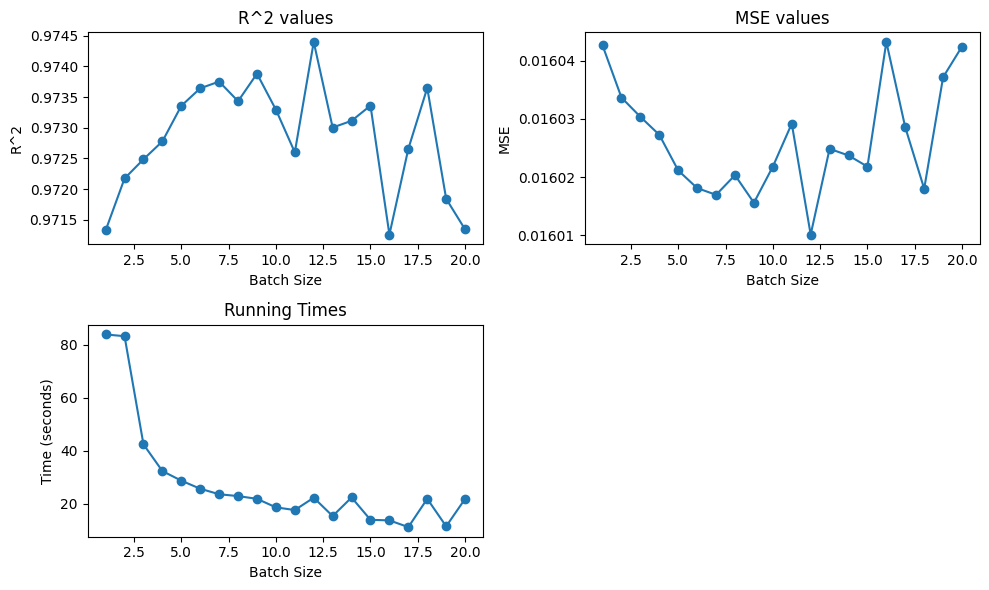

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import time
import matplotlib.pyplot as plt

# Initialize lists to store results
r2_values = []
mse_values = []
running_times = []

# Fix the number of neurons
num_hidden = 2
i = 2
# Define the range of batch sizes
batch_sizes = range(1, 21)

# Loop over batch sizes
for batch_size in batch_sizes:
    with tf.device('/gpu:0'):
        x = autoencoder.get_layer('encoder2').output
        x = Dropout(0.2)(x)  # adding 20% dropout
        h = Dense(int(num_hidden * 3), activation='relu', name='hidden1')(x)
        h = Dropout(0.5)(h)  # adding 50% dropout
        h = Dense(int(num_hidden * 5), activation='relu', name='hidden2')(h)
        h = Dropout(0.5)(h)  # adding 50% dropout
        h = Dense(int(num_hidden * i), activation='relu', name='hidden3')(h)
        h = Dropout(0.5)(h)  # adding 50% dropout
        y = Dense(num_out_neurons, activation='linear', name='prediction')(h)
        mlpRegressor = Model(inputs=autoencoder.inputs, outputs=y)

        # Compile model
        mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])  # or loss='mae'

        # Fit the model
        print('Training the MLP multi-output regressor with batch size {}'.format(batch_size))
        start_time = time.time()  # Record the start time
        history = mlpRegressor.fit(x_train, y_train, epochs=50, batch_size=batch_size, verbose=0)
        end_time = time.time()  # Record the end time
        running_time = end_time - start_time  # Calculate the running time
        running_times.append(running_time)

        # Predict on test data
        y_pred = mlpRegressor.predict(x_test)

        actual_mean = pd.DataFrame(y_test.mean(axis=0))
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(actual_mean, pred_mean)
        mse_values.append(mse)
        r2_values.append(r2)
        # Print results
        print("The code took {:.2f} seconds to run.".format(running_time))
        print('MSE: (Actual Vs. Predicted)', mse)
        print('r^2 value:', r2)

# Plotting
plt.figure(figsize=(10, 6))

# Plot R^2 values
plt.subplot(2, 2, 1)
plt.plot(batch_sizes, r2_values, marker='o', linestyle='-')
plt.title('R^2 values')
plt.xlabel('Batch Size')
plt.ylabel('R^2')

# Plot MSE values
plt.subplot(2, 2, 2)
plt.plot(batch_sizes, mse_values, marker='o', linestyle='-')
plt.title('MSE values')
plt.xlabel('Batch Size')
plt.ylabel('MSE')

# Plot running times
plt.subplot(2, 2, 3)
plt.plot(batch_sizes, running_times, marker='o', linestyle='-')
plt.title('Running Times')
plt.xlabel('Batch Size')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()


Testing the best number of hidden neurons

```
# This is formatted as code
```



Training the MLP multi-output regressor with 200 neurons in the third hidden layer
3/3 [==============================] - 0s 5ms/step
The code took 21.77 seconds to run.
MSE: (Actual Vs. Predicted) 0.01604510860984434
r^2 value: 0.9710882608417
Training the MLP multi-output regressor with 400 neurons in the third hidden layer
3/3 [==============================] - 0s 5ms/step
The code took 23.84 seconds to run.
MSE: (Actual Vs. Predicted) 0.016041332038261906
r^2 value: 0.9714455497058346
Training the MLP multi-output regressor with 600 neurons in the third hidden layer
3/3 [==============================] - 0s 6ms/step
The code took 42.23 seconds to run.
MSE: (Actual Vs. Predicted) 0.016058364094812875
r^2 value: 0.9698341960251137
Training the MLP multi-output regressor with 800 neurons in the third hidden layer
3/3 [==============================] - 0s 6ms/step
The code took 42.33 seconds to run.
MSE: (Actual Vs. Predicted) 0.01608733707290864
r^2 value: 0.9670931457503436
Training 

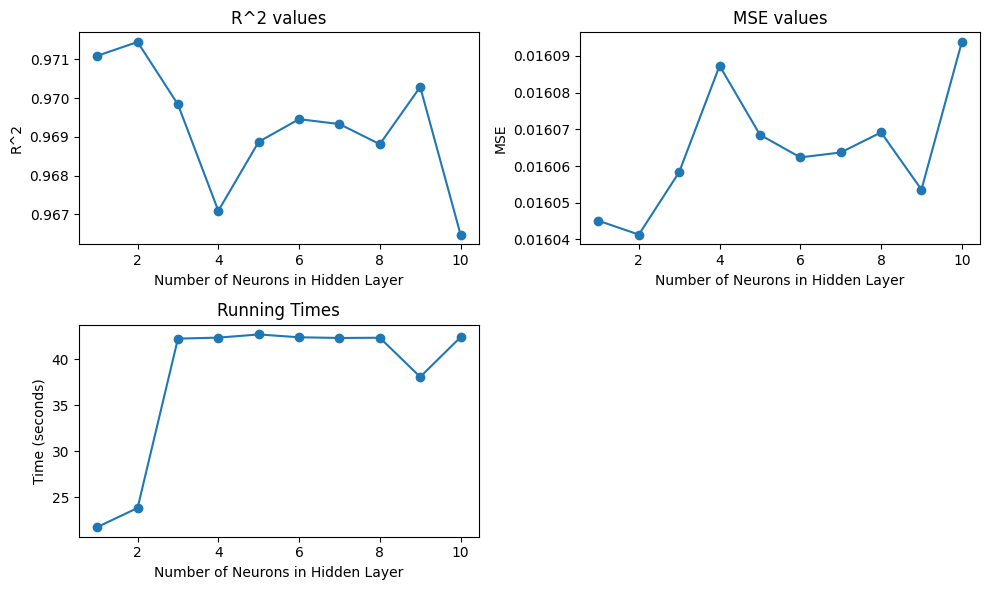

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import time
import matplotlib.pyplot as plt

# Initialize lists to store results
r2_values = []
mse_values = []
running_times = []

# Define the range of values for i
for i in range(1, 11):
    num_hidden = encoding_dim2

    with tf.device('/gpu:0'):
        x = autoencoder.get_layer('encoder2').output
        x = Dropout(0.2)(x)  # adding 20% dropout
        h = Dense(int(num_hidden * 3), activation='relu', name='hidden1')(x)
        h = Dropout(0.5)(h)  # adding 50% dropout
        h = Dense(int(num_hidden * 5), activation='relu', name='hidden2')(h)
        h = Dropout(0.5)(h)  # adding 50% dropout
        h = Dense(int(num_hidden * i), activation='relu', name='hidden3')(h)
        h = Dropout(0.5)(h)  # adding 50% dropout
        y = Dense(num_out_neurons, activation='linear', name='prediction')(h)
        mlpRegressor = Model(inputs=autoencoder.inputs, outputs=y)

        # Compile model
        mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])  # or loss='mae'

        # Fit the model
        print('Training the MLP multi-output regressor with {} neurons in the third hidden layer'.format(num_hidden * i))
        start_time = time.time()  # Record the start time
        history = mlpRegressor.fit(x_train, y_train, epochs=50, batch_size=8, verbose=0)
        end_time = time.time()  # Record the end time
        running_time = end_time - start_time  # Calculate the running time
        running_times.append(running_time)

        # Predict on test data
        y_pred = mlpRegressor.predict(x_test)

        actual_mean = pd.DataFrame(y_test.mean(axis=0))
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(actual_mean, pred_mean)
        mse_values.append(mse)
        r2_values.append(r2)

        # Print results
        print("The code took {:.2f} seconds to run.".format(running_time))
        print('MSE: (Actual Vs. Predicted)', mse)
        print('r^2 value:', r2)

# Plotting
plt.figure(figsize=(10, 6))

# Plot R^2 values
plt.subplot(2, 2, 1)
plt.plot(range(1, 11), r2_values, marker='o', linestyle='-')
plt.title('R^2 values')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('R^2')

# Plot MSE values
plt.subplot(2, 2, 2)
plt.plot(range(1, 11), mse_values, marker='o', linestyle='-')
plt.title('MSE values')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('MSE')

# Plot running times
plt.subplot(2, 2, 3)
plt.plot(range(1, 11), running_times, marker='o', linestyle='-')
plt.title('Running Times')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()


# Regression using MLP

In [ ]:
scaled_splits[1]

(array([[0.44444444, 0.44444444],
        [1.        , 1.        ],
        [0.22222222, 0.22222222],
        [0.66666667, 0.66666667],
        [0.        , 0.        ],
        [0.11111111, 0.11111111],
        [0.55555556, 0.55555556],
        [0.77777778, 0.77777778]]),
 array([[0.33333333, 0.33333333],
        [0.88888889, 0.88888889]]),
             0         1         2         3         4         5         6  \
 185  0.237516  0.253400  0.143199  0.595890  0.220132  0.030408  0.156484   
 227  0.254547  0.465353  0.052324  0.095771  0.218544  0.056777  0.061750   
 245  0.135876  0.362625  0.145721  0.473141  0.023718  0.031705  0.071791   
 23   0.323092  0.443721  0.145171  0.076528  0.054669  0.048524  0.072960   
 321  0.110044  0.290947  0.102425  0.089025  0.080920  0.011588  0.114734   
 ..        ...       ...       ...       ...       ...       ...       ...   
 255  0.369365  0.359735  0.114441  0.169862  0.076747  0.047665  0.046109   
 72   0.495649  0.328663  0.0119

MLP by K-fold

In [ ]:
import pandas as pd
import time
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers import Dropout, Dense
from keras.models import Model
import tensorflow as tf

num_in_neurons = z.shape[1]
num_out_neurons = y.shape[1]

# Assuming you have 5 sets of scaled data in scaled_splits and 5 autoencoders
for i, (X_train, X_test, y_train, y_test,a,b) in enumerate(scaled_splits, 1):
    x_train_noisy = x_train_noisy_list[i-1]
    autoencoder = autoencoders[i-1]
   # provide your x_test and y_test datasets here appropriately
    num_hidden = encoding_dim2
    with tf.device('/gpu:0'):
        # Creating the MLP regressor
        x = autoencoder.get_layer('encoder2').output
        x = Dropout(0.2)(x)
        h = Dense(int(num_hidden * 3), activation='relu', name='hidden1_{}'.format(i))(x)
        h = Dropout(0.5)(h)
        h = Dense(int(num_hidden * 5), activation='relu', name='hidden2_{}'.format(i))(h)
        h = Dropout(0.5)(h)
        h = Dense(int(num_hidden * 2), activation='relu', name='hidden3_{}'.format(i))(h)
        h = Dropout(0.5)(h)
        y = Dense(num_out_neurons, activation='linear', name='prediction_{}'.format(i))(h)
        mlpRegressor = Model(inputs=autoencoder.inputs, outputs=y)

        # Compile model
        mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])  # or loss='mae'

        # Train the model
        print('Training the MLP multi-output regressor for model', i)
        start_time = time.time()  # Make sure to initialize start_time at the right place in your script
        mlpRegressor.fit(X_train, y_train, epochs=50, batch_size=12,verbose = 0)

        # Perform predictions with the trained MLP regressor
        y_pred = mlpRegressor.predict(X_test)

        # Calculate and print statistics
        actual_mean = pd.DataFrame(y_test.mean(axis=0))
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        print('Training the MLP multi-output regressor for model', i)
        print('MSE for model {}:'.format(i + 1), mean_squared_error(y_test, y_pred))
        print('r^2 value for model {}:'.format(i + 1), r2_score(actual_mean, pred_mean))
        print('Actual Means for model {}:'.format(i + 1))
        #print(actual_mean)
        print('Predicted Means for model {}:'.format(i + 1))
        #print(pred_mean)

# Record the end time
        end_time = time.time()
# Calculate the running time
        running_time = end_time - start_time

        print("Total code execution took {:.2f} seconds.".format(running_time))
        plt.tight_layout()



Training the MLP multi-output regressor for model 1
3/3 [==============================] - 0s 5ms/step
Training the MLP multi-output regressor for model 1
MSE for model 2: 0.016656706830857515
r^2 value for model 2: 0.9786523459211449
Actual Means for model 2:
Predicted Means for model 2:
Total code execution took 42.59 seconds.
Training the MLP multi-output regressor for model 2
3/3 [==============================] - 0s 6ms/step
Training the MLP multi-output regressor for model 2
MSE for model 3: 0.01720575145293418
r^2 value for model 3: 0.9798811345303494
Actual Means for model 3:
Predicted Means for model 3:
Total code execution took 22.62 seconds.
Training the MLP multi-output regressor for model 3
3/3 [==============================] - 0s 5ms/step
Training the MLP multi-output regressor for model 3
MSE for model 4: 0.017951829253348366
r^2 value for model 4: 0.9786533060851745
Actual Means for model 4:
Predicted Means for model 4:
Total code execution took 42.53 seconds.
Training

<Figure size 640x480 with 0 Axes>

Try using optimized parameters for MLP

In [ ]:
import pandas as pd
import time
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers import Dropout, Dense
from keras.models import Model
import tensorflow as tf

num_in_neurons = z.shape[1]
num_out_neurons = y.shape[1]

# Assuming you have 5 sets of scaled data in scaled_splits and 5 autoencoders
for i, (X_train, X_test, y_train, y_test,a,b) in enumerate(scaled_splits, 1):
    x_train_noisy = x_train_noisy_list[i-1]
    autoencoder = autoencoders[i-1]
   # provide your x_test and y_test datasets here appropriately
    num_hidden = encoding_dim2
    with tf.device('/gpu:0'):
        # Creating the MLP regressor
        x = autoencoder.get_layer('encoder2').output
        x = Dropout(0.2)(x)
        h = Dense(int(num_hidden * 3), activation='relu', name='hidden1_{}'.format(i))(x)
        h = Dropout(0.5)(h)
        h = Dense(int(num_hidden * 5), activation='relu', name='hidden2_{}'.format(i))(h)
        h = Dropout(0.5)(h)
        h = Dense(int(num_hidden * 2), activation='relu', name='hidden3_{}'.format(i))(h)
        h = Dropout(0.5)(h)
        y = Dense(num_out_neurons, activation='linear', name='prediction_{}'.format(i))(h)
        mlpRegressor = Model(inputs=autoencoder.inputs, outputs=y)

        # Compile model
        mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])  # or loss='mae'

        # Train the model
        print('Training the MLP multi-output regressor for model', i)
        start_time = time.time()  # Make sure to initialize start_time at the right place in your script
        mlpRegressor.fit(X_train, y_train, epochs=50, batch_size=12,verbose = 0)

        # Perform predictions with the trained MLP regressor
        y_pred = mlpRegressor.predict(X_test)

        # Calculate and print statistics
        actual_mean = pd.DataFrame(y_test.mean(axis=0))
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        print('Training the MLP multi-output regressor for model', i)
        print('MSE for model {}:'.format(i + 1), mean_squared_error(y_test, y_pred))
        print('r^2 value for model {}:'.format(i + 1), r2_score(actual_mean, pred_mean))
        print('Actual Means for model {}:'.format(i + 1))
        #print(actual_mean)
        print('Predicted Means for model {}:'.format(i + 1))
        #print(pred_mean)

# Record the end time
        end_time = time.time()
# Calculate the running time
        running_time = end_time - start_time

        print("Total code execution took {:.2f} seconds.".format(running_time))
        plt.tight_layout()



Training the MLP multi-output regressor for model 1
3/3 [==============================] - 0s 5ms/step
Training the MLP multi-output regressor for model 1
MSE for model 2: 0.016633434414126222
r^2 value for model 2: 0.9807606212342798
Actual Means for model 2:
Predicted Means for model 2:
Total code execution took 20.96 seconds.
Training the MLP multi-output regressor for model 2
3/3 [==============================] - 0s 5ms/step
Training the MLP multi-output regressor for model 2
MSE for model 3: 0.017212678284614702
r^2 value for model 3: 0.9791949019366458
Actual Means for model 3:
Predicted Means for model 3:
Total code execution took 17.09 seconds.
Training the MLP multi-output regressor for model 3
3/3 [==============================] - 0s 4ms/step
Training the MLP multi-output regressor for model 3
MSE for model 4: 0.017966138874129924
r^2 value for model 4: 0.9772625499798736
Actual Means for model 4:
Predicted Means for model 4:
Total code execution took 17.65 seconds.
Trainin

<Figure size 640x480 with 0 Axes>

In [ ]:
# MLP Multi-output Regression code goes here...
# Auto-encoder to extract features from DNA Methylation and CNV data
import time
# Record the start time
start_time = time.time()
num_hidden = encoding_dim2
with tf.device('/gpu:0'):
    x = autoencoder.get_layer('encoder2').output
    x = Dropout(0.2)(x)             # adding 20% dropout
    h = Dense(int(num_hidden * 3), activation='relu', name='hidden1')(x)
    h = Dropout(0.5)(h)             # adding 50% dropout
    h = Dense(int(num_hidden * 5), activation='relu', name='hidden2')(h)
    h = Dropout(0.5)(h)             # adding 50% dropout
    h = Dense(int(num_hidden * 2), activation='relu', name='hidden3')(h)
    h = Dropout(0.5)(h)             # adding 50% dropout
    y = Dense(num_out_neurons, activation='linear', name='prediction')(h)
    mlpRegressor = Model(inputs=autoencoder.inputs, outputs=y)

    # Compile model
    mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])    # or loss='mae'

    # Fit the model
    # Fit the model
    print('training the MLP multi-output regressor')
    mlpRegressor.fit(x_train, y_train, epochs=50, batch_size=12)

    y_pred = mlpRegressor.predict(x_test)

    actual_mean = pd.DataFrame(y_test.mean(axis=0))
    pred_mean = pd.DataFrame(y_pred.mean(axis=0))
# Record the end time
end_time = time.time()

# Calculate the running time
running_time = end_time - start_time



training the MLP multi-output regressor
Epoch 1/50
27/27 [==============================] - 4s 19ms/step - loss: 0.2591 - accuracy: 0.0000e+00
Epoch 2/50
27/27 [==============================] - 0s 13ms/step - loss: 0.2416 - accuracy: 0.0000e+00
Epoch 3/50
27/27 [==============================] - 0s 14ms/step - loss: 0.2405 - accuracy: 0.0000e+00
Epoch 4/50
27/27 [==============================] - 0s 14ms/step - loss: 0.2406 - accuracy: 0.0000e+00
Epoch 5/50
27/27 [==============================] - 0s 15ms/step - loss: 0.2387 - accuracy: 0.0000e+00
Epoch 6/50
27/27 [==============================] - 0s 17ms/step - loss: 0.2395 - accuracy: 0.0000e+00
Epoch 7/50
27/27 [==============================] - 0s 17ms/step - loss: 0.2387 - accuracy: 0.0000e+00
Epoch 8/50
27/27 [==============================] - 0s 16ms/step - loss: 0.2388 - accuracy: 0.0000e+00
Epoch 9/50
27/27 [==============================] - 0s 18ms/step - loss: 0.2384 - accuracy: 0.0000e+00
Epoch 10/50
27/27 [==============

In [ ]:
print("The code took {:.2f} seconds to run.".format(running_time))
print('MSE: (Actual Vs. Predicted)', mean_squared_error(y_test, y_pred))
print('r^2 value: (Mean of actual Vs. Mean of Predicted)', r2_score(actual_mean, pred_mean))
print(actual_mean)
print(pred_mean)

The code took 26.03 seconds to run.
MSE: (Actual Vs. Predicted) 0.025589013423627172
r^2 value: (Mean of actual Vs. Mean of Predicted) 0.9807089609027235
             0
0     0.188308
1     0.676369
2     0.335262
3     0.369018
4     0.518840
...        ...
9026  0.732846
9027  0.474024
9028  0.472701
9029  0.365537
9030  0.516078

[9031 rows x 1 columns]
             0
0     0.193913
1     0.682213
2     0.355746
3     0.343737
4     0.529345
...        ...
9026  0.731419
9027  0.467441
9028  0.471372
9029  0.407475
9030  0.516387

[9031 rows x 1 columns]


In [ ]:
y_pred.shape
#y_test.shape

(111, 9031)

# Results

In [ ]:

print('MSE: (Actual Vs. Predicted)', mean_squared_error(y_test, y_pred))
print('r^2 value: (Mean of actual Vs. Mean of Predicted)', r2_score(actual_mean, pred_mean))

MSE: (Actual Vs. Predicted) 0.016820339095266326
r^2 value: (Mean of actual Vs. Mean of Predicted) 0.9770348322775801


Plotting predicted Vs. Actual

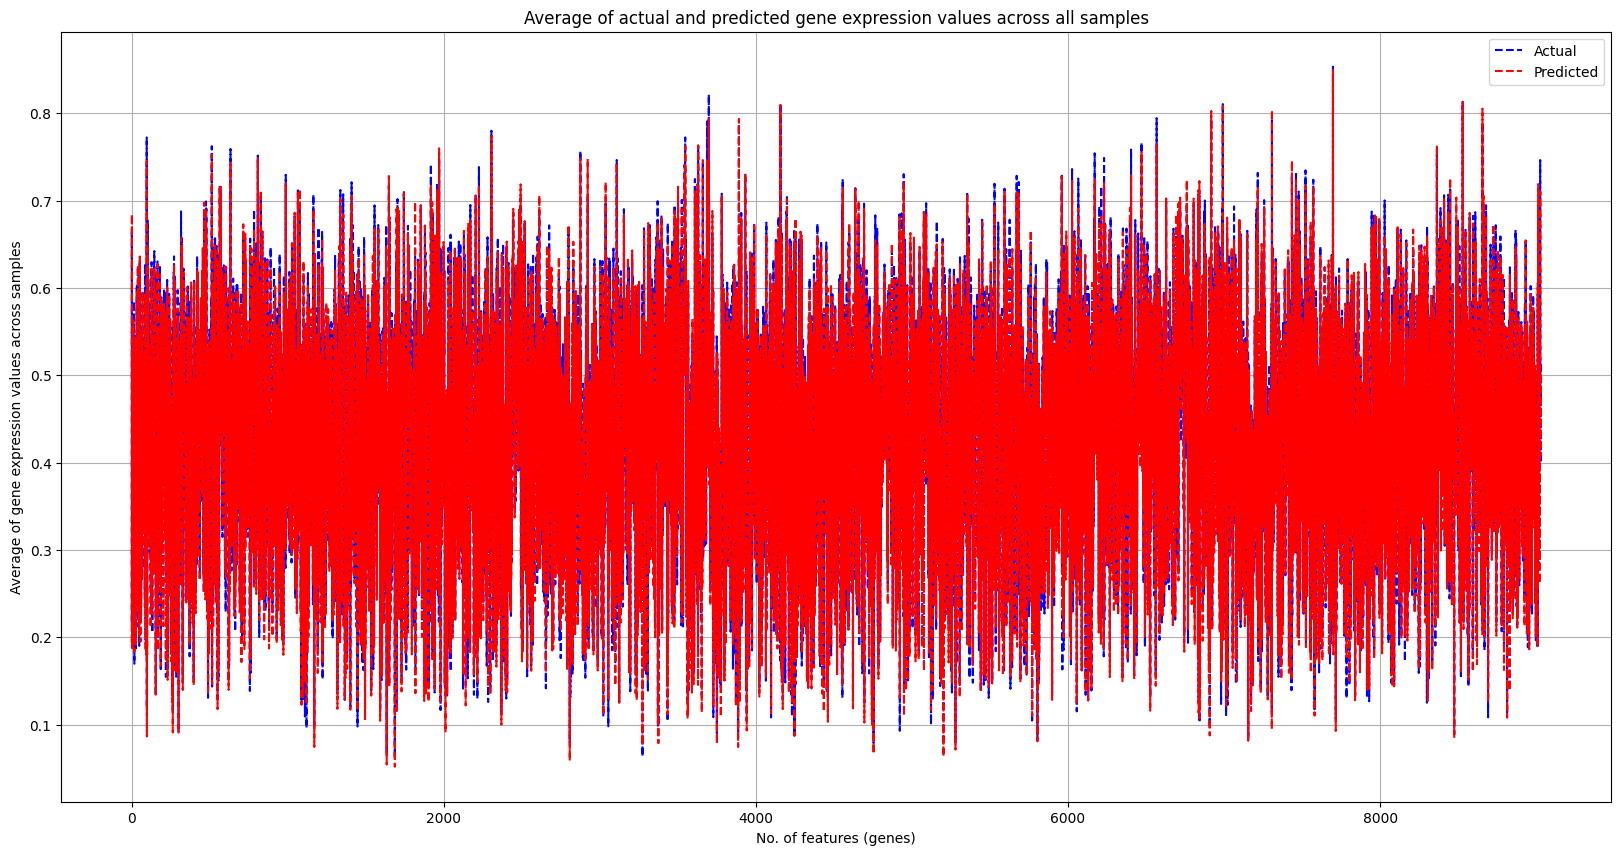

In [ ]:
act=actual_mean.values.flatten()
pred=pred_mean.values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(20,10))
ax = plt.subplot(111)
plt.title('Average of actual and predicted gene expression values across all samples')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

Plotting first 100 features

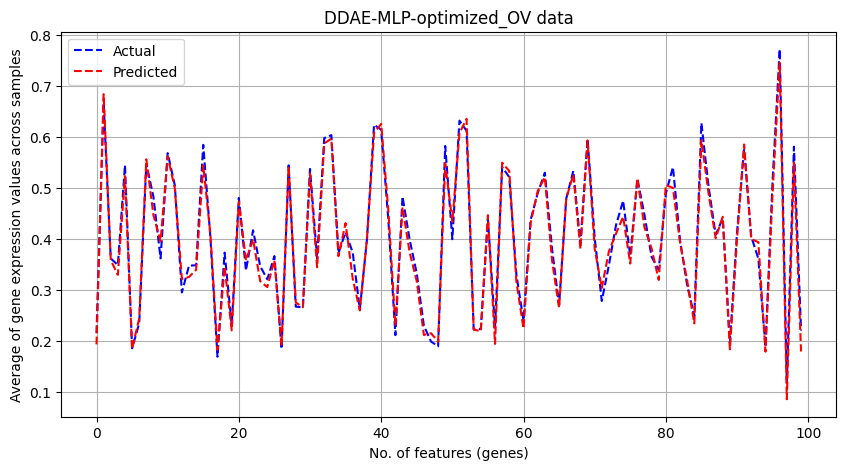

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('DDAE-MLP-optimized_OV data')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

Plotting correlation scatter plot for mean of actual Vs. mean of predicted gene expressions

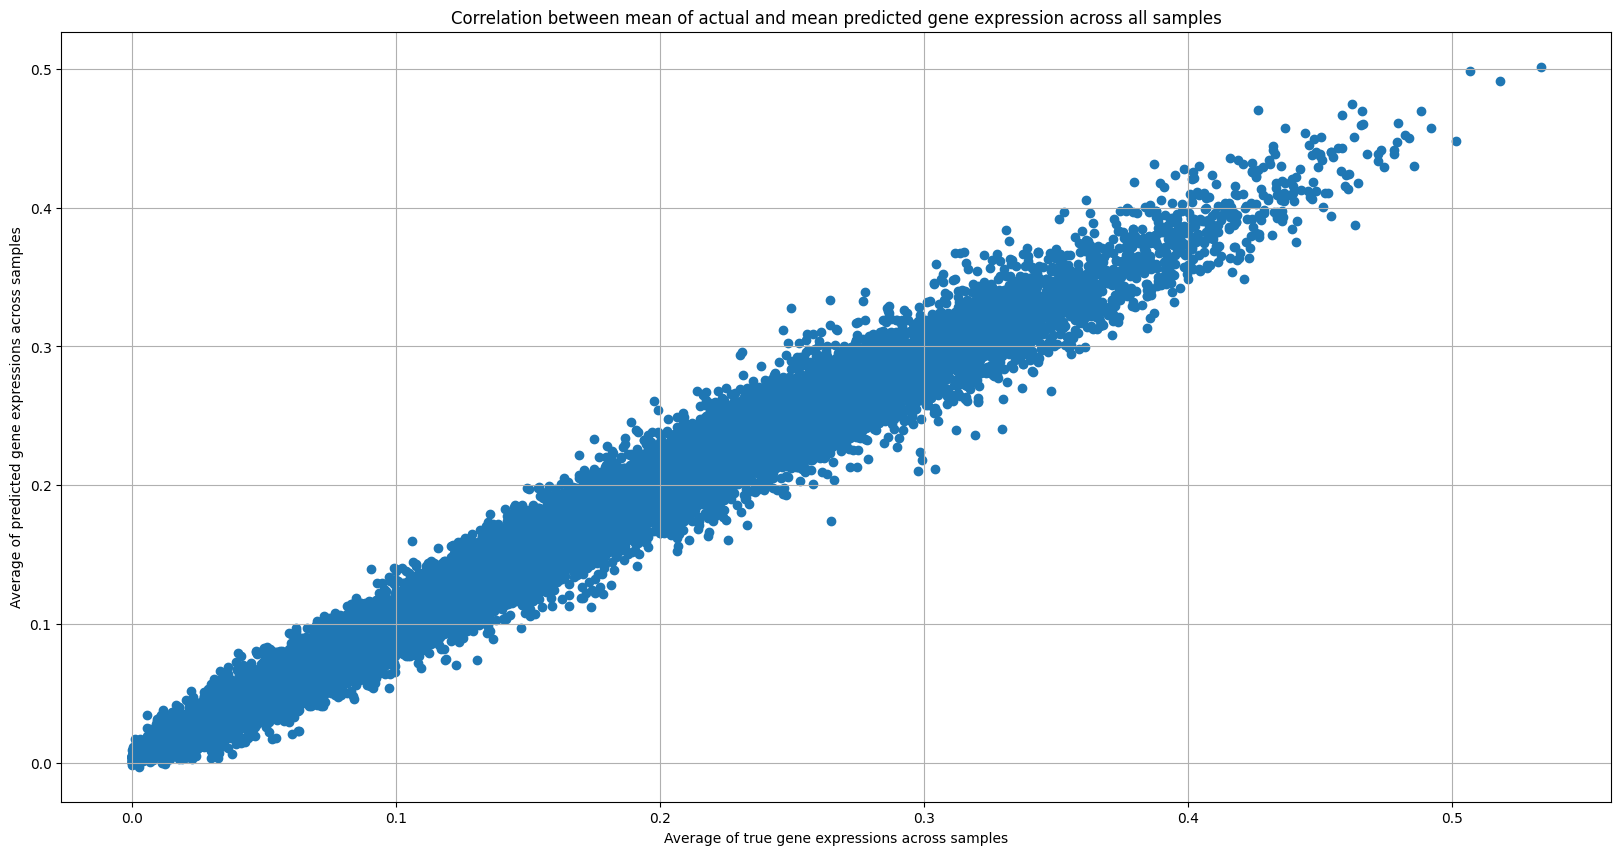

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(actual_mean, pred_mean)
plt.title('Correlation between mean of actual and mean predicted gene expression across all samples')
plt.xlabel('Average of true gene expressions across samples')
plt.ylabel('Average of predicted gene expressions across samples')
plt.grid(True)
plt.show()


# Classification of Tumor and Normal samples using MLP

Importing libraries

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

MLP-classifier

In [ ]:
num_hidden = encoding_dim2
with tf.device('/gpu:0'):
    x = autoencoder.get_layer('encoder2').output
    x = Dropout(0.2)(x)     # adding 20% dropout
    h = Dense(int(num_hidden * 3), activation='relu', name='hidden1')(x)
    h = Dropout(0.5)(h)     # adding 50% dropout
    h = Dense(int(num_hidden * 5), activation='relu', name='hidden2')(h)
    h = Dropout(0.5)(h)     # adding 50% dropout
    y = Dense(1, activation='sigmoid', name='predictions')(h)

    classifier = Model(inputs=autoencoder.inputs, outputs=y)
    # Compile model
    classifier.compile(loss='binary_crossentropy', optimizer='adam',
                   metrics=['accuracy'])
    # Fit the model
    classifier.fit(x_train, labels_train, epochs=25, batch_size=8)

    print('Now making predictions')
    predictions = classifier.predict(x_test)
    rounded_predictions = [round(x[0]) for x in predictions]

Epoch 1/25
41/41 [==============================] - 2s 5ms/step - loss: 0.9973 - accuracy: 0.8854
Epoch 2/25
41/41 [==============================] - 0s 5ms/step - loss: 0.6944 - accuracy: 0.9009
Epoch 3/25
41/41 [==============================] - 0s 5ms/step - loss: 0.7203 - accuracy: 0.8793
Epoch 4/25
41/41 [==============================] - 0s 5ms/step - loss: 0.6892 - accuracy: 0.9040
Epoch 5/25
41/41 [==============================] - 0s 5ms/step - loss: 0.6117 - accuracy: 0.9071
Epoch 6/25
41/41 [==============================] - 0s 5ms/step - loss: 0.5977 - accuracy: 0.9133
Epoch 7/25
41/41 [==============================] - 0s 5ms/step - loss: 0.5843 - accuracy: 0.9071
Epoch 8/25
41/41 [==============================] - 0s 5ms/step - loss: 0.6131 - accuracy: 0.9102
Epoch 9/25
41/41 [==============================] - 0s 5ms/step - loss: 0.5966 - accuracy: 0.9102
Epoch 10/25
41/41 [==============================] - 0s 5ms/step - loss: 0.5899 - accuracy: 0.9133
Epoch 11/25
41/41 [

In [ ]:
from keras.layers import LeakyReLU, Dense, Dropout
from keras.models import Model
import tensorflow as tf

num_hidden = encoding_dim2

with tf.device('/gpu:0'):
    x = autoencoder.get_layer('encoder2').output
    x = Dropout(0.2)(x)  # adding 20% dropout
    h = Dense(int(num_hidden * 3), name='hidden1')(x)
    h = LeakyReLU(alpha=0.01)(h)  # applying LeakyReLU
    h = Dropout(0.5)(h)  # adding 50% dropout
    h = Dense(int(num_hidden * 5), name='hidden2')(h)
    h = LeakyReLU(alpha=0.01)(h)  # applying LeakyReLU
    h = Dropout(0.5)(h)  # adding 50% dropout
    y = Dense(1, activation='sigmoid', name='predictions')(h)

    classifier = Model(inputs=autoencoder.inputs, outputs=y)
    # Compile model
    classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Assuming x_train, labels_train, x_test are already defined and preprocessed appropriately
classifier.fit(x_train, labels_train, epochs=25, batch_size=8)

print('Now making predictions')
predictions = classifier.predict(x_test)
rounded_predictions = [round(x[0]) for x in predictions]


Epoch 1/25
41/41 [==============================] - 3s 11ms/step - loss: 1.1319 - accuracy: 0.8793
Epoch 2/25
41/41 [==============================] - 0s 10ms/step - loss: 0.7900 - accuracy: 0.8700
Epoch 3/25
41/41 [==============================] - 0s 8ms/step - loss: 0.8340 - accuracy: 0.8762
Epoch 4/25
41/41 [==============================] - 0s 5ms/step - loss: 0.7693 - accuracy: 0.9009
Epoch 5/25
41/41 [==============================] - 0s 6ms/step - loss: 0.7200 - accuracy: 0.8824
Epoch 6/25
41/41 [==============================] - 0s 6ms/step - loss: 0.6720 - accuracy: 0.9133
Epoch 7/25
41/41 [==============================] - 0s 5ms/step - loss: 0.6638 - accuracy: 0.8978
Epoch 8/25
41/41 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.9164
Epoch 9/25
41/41 [==============================] - 0s 6ms/step - loss: 0.6137 - accuracy: 0.9071
Epoch 10/25
41/41 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.9071
Epoch 11/25
41/41

3/3 [==============================] - 0s 7ms/step


Evaluating the model

In [ ]:
_, train_acc = classifier.evaluate(x_train, labels_train, verbose=0)
_, test_acc = classifier.evaluate(x_test, labels_test, verbose=0)
print('\nTraining accuracy: %.3f, Testing accuracy: %.3f' % (train_acc, test_acc))
print("Recall score = ",recall_score(labels_test, rounded_predictions))
cm = confusion_matrix(labels_test, rounded_predictions)
print("Confusion matrix:")
print(cm)
report = classification_report(labels_test, rounded_predictions)
print("classification_report")
print(report)


Training accuracy: 0.913, Testing accuracy: 0.864
Recall score =  1.0
Confusion matrix:
[[ 0 11]
 [ 0 70]]
classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.86      1.00      0.93        70

    accuracy                           0.86        81
   macro avg       0.43      0.50      0.46        81
weighted avg       0.75      0.86      0.80        81



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Mean Squared Error (y_test Vs. y_pred): ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Mean Squared Error (y_test Vs. y_pred):  0.02138677421372334
r2 Score (y_test_mean Vs. y_pred_mean):  0.9849136113430523


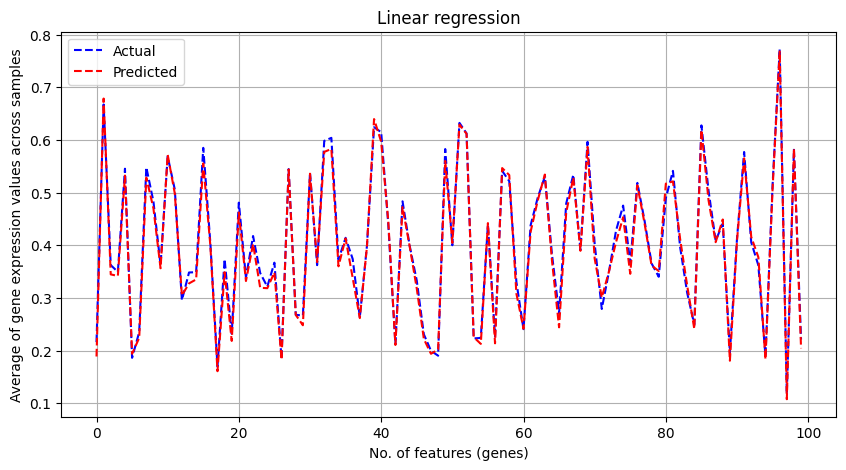

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('Linear regression')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

Plotting first 100 features

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('Linear Regression')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# 2. Lasso

Importing libraries

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

Multi-output regression using Lasso (sk-learn)

In [ ]:
y_mse=[]
y_r2score=[]
with tf.device('/gpu:0'):
    #for alp in [0.1, 0.2, 0.3, 0.4, 0.5]
    for alp in [0.01,0.1,0.5,1,5]:
        print('Working with alpha=',alp)
        Lasso_Regr = Lasso(alpha=alp, normalize=True, random_state=42)
        Lasso_Regr.fit(x_train, y_train)
        y_pred = Lasso_Regr.predict(x_test)
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        y_mse.append(mean_squared_error(y_test, y_pred))
        y_r2score.append(r2_score(actual_mean, pred_mean))

In [ ]:
print("Mean Squared Error (y_test Vs. y_pred): ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Plotting first 100 features

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('Lasso with alpha = 1.5')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# 3. Ridge

Importing libraries

In [ ]:
from sklearn.linear_model import Ridge

Multi-output regression using Ridge (sk-learn)

In [ ]:
y_mse=[]
y_r2score=[]
with tf.device('/gpu:0'):
    for alp in [0.01,0.1,0.5,1,1.5]:
        print('Working with alpha = ',alp)
        Ridge_Regr = Ridge(alpha=alp, normalize=True)
        Ridge_Regr.fit(x_train, y_train)
        y_pred = Ridge_Regr.predict(x_test)
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        y_mse.append(mean_squared_error(y_test, y_pred))
        y_r2score.append(r2_score(actual_mean, pred_mean))

Working with alpha =  0.01


TypeError: Ridge.__init__() got an unexpected keyword argument 'normalize'

In [ ]:
print("Mean Squared Error (y_test Vs. y_pred): ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Plotting first 100 features

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('Ridge Regression with alpha=1.5')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# 4. PCA - Random Forest (PCA-RF)

Importing libraries

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [ ]:
n=200
pca = PCA(n_components=n)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

Multi-output regression using Random Forest (sk-learn)

In [ ]:
y_mse=[]
y_r2score=[]
with tf.device('/gpu:0'):
    for est in [10,50,100,150,200]:
        print('estimators = ',est)
        rf_Regr = RandomForestRegressor(n_estimators=est, n_jobs=-1)
        rf_Regr.fit(x_train, y_train)
        y_pred = rf_Regr.predict(x_test)
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        y_mse.append(mean_squared_error(y_test, y_pred))
        y_r2score.append(r2_score(actual_mean, pred_mean))

estimators =  10
estimators =  50
estimators =  100
estimators =  150
estimators =  200


In [ ]:
print("Mean Squared Error: ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Mean Squared Error:  [0.02617521850030308, 0.02440568477126708, 0.02399789213211442, 0.02419010429827646, 0.02399456466796197]
r2 Score (y_test_mean Vs. y_pred_mean):  [0.9794622612848929, 0.9789434692511437, 0.9785505273715964, 0.9794037797013054, 0.9794683895313168]


Plotting first 100 features

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('PCA-RF with 250 features and 100 estimators')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# 5. k-Nearest Neighbor (kNN)

Importing libraries

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

Multi-output regression using kNN (sk-learn)

In [ ]:
y_mse=[]
y_r2score=[]
with tf.device('/gpu:0'):
    for k in [5,10,15,20,25]:
        print('k=',k)
        knn_Regr = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
        knn_Regr.fit(x_train, y_train)
        y_pred = knn_Regr.predict(x_test)
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        y_mse.append(mean_squared_error(y_test, y_pred))
        y_r2score.append(r2_score(actual_mean, pred_mean))

In [ ]:
print("Mean Squared Error: ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Plotting first 100 features

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('k-NN with k=10')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# 6. PCA - Support Vector Regression (PCA-SVR)

In [ ]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA

In [ ]:
n=200
pca = PCA(n_components=n)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

In [ ]:
with tf.device('/gpu:0'):
    y_mse=[]
    y_r2score = []
    for k in ['linear','poly','rbf','sigmoid']:
        print('kernel = ',k)
        mo_svr = MultiOutputRegressor(SVR(kernel=k,gamma='auto'))
        mo_svr.fit(x_train, y_train)
        y_pred = mo_svr.predict(x_test)
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        y_mse.append(mean_squared_error(y_test, y_pred))
        y_r2score.append(r2_score(actual_mean, pred_mean))

In [ ]:
print("Mean Squared Error: ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Plotting first 100 features

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('PCA-RF with 250 features and linear kernel')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# Comparison regression results from AE-MLP with PCA-MLP

Importing libraries

In [ ]:
from sklearn.decomposition import PCA

PCA-MLP

In [ ]:
n=100
with tf.device('/gpu:0'):
    #pca
    pca = PCA(n_components=n)
    pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)

    # MLP Multi-output Regression code goes here...
    num = n
    input_data = Input(shape=(num,))
    x = Dropout(0.2)(input_data)             # adding 20% dropout
    h = Dense(int(num * 3), activation='relu', name='hidden1')(x)
    h = Dropout(0.5)(h)                        # adding 50% dropout
    h = Dense(int(num * 5), activation='relu', name='hidden2')(h)
    h = Dropout(0.5)(h)                        # adding 50% dropout
    y = Dense(num_out_neurons, activation='linear', name='prediction')(h)
    mlpRegressor = Model(inputs=input_data, outputs=y)

    # Compile model
    mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])    # or loss='mae'
    # Fit the model
    print('training the MLP multi-output regressor')
    mlpRegressor.fit(x_train, y_train, epochs=50, batch_size=8)
    y_pred = mlpRegressor.predict(x_test)
    actual_mean = pd.DataFrame(y_test.mean(axis=0))
    pred_mean = pd.DataFrame(y_pred.mean(axis=0))

Printing results

In [ ]:
print('MSE: (Actual Vs. Predicted)', mean_squared_error(y_test, y_pred))
print('r^2 value: (Mean of actual Vs. Mean of Predicted)', r2_score(actual_mean, pred_mean))